In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
warnings.filterwarnings(action='once')

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
reload(utils_jjm)
reload(dlc_utils)

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 18:25:44.352087. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


<module 'dlc_utils' from '/home/jma819/post_cmfe_analysis/dlc_utils.py'>

In [3]:
#cnmfe_file_key = pd.read_csv('/Volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/cnmfe_key.csv')
cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_key.csv')

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 18:25:45.272220. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [4]:
#cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_files = ['29-Jan_12_35_06_out.mat','30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['30-Jan_16_54_31_out.mat','30-Jan_14_00_19_out.mat','31-Jan_01_43_49_out.mat','31-Jan_00_12_24_out.mat','31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 18:25:51.681372. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [5]:
#tracking_files = ['/Volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_files] 
tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_files] 

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 18:26:50.596468. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [6]:
#tracking_files

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 18:26:51.978265. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [7]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in wt_CNMFE_files]
#CNMFE_dir_paths_list

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 18:26:53.949644. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [8]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 18:27:01.195735. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


## triggered averaging 

In [9]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = .2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=50)

V_df['velocity_bins'] = all_sessions_v_bins

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 18:30:00.689448. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [10]:
#V_df.index

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 18:30:01.965865. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [54]:
filtered_for_analysis = {}
filtered_for_analysis_normalized = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
    filtered_for_analysis_normalized[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
C_norm_df = pd.concat([filtered_for_analysis_normalized[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))


/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 19:04:52.165747. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [78]:
C_norm_df.loc['GRIN039_H12_M26_S54'].head()

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 19:11:42.032432. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,1,2,3,4,6,8,9,10,11,12,...,164,165,166,167,168,169,170,121,139,152
00:00:00,0.095848,0.063020,0.035247,0.144497,0.726842,0.726884,0.731344,0.190506,0.046192,0.136891,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.200000,0.134261,0.065264,0.032855,0.180691,0.726880,0.726865,0.729842,0.166479,0.018765,0.136579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.400000,0.100912,0.062636,0.024803,0.222096,0.726877,0.726877,0.740098,0.148097,0.007623,0.124246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.600000,0.120691,0.061244,0.018724,0.177142,0.726900,0.726852,0.742373,0.183535,0.003097,0.114494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.800000,0.144409,0.075907,0.017802,0.247447,0.726912,0.726852,0.739828,0.165513,0.001258,0.111559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#need to make sure x axis from velocity binned df matches axis from grouped raw data 

In [60]:
binned_velocity_df.head()

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 19:07:47.378614. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,GRIN039_H12_M26_S54,GRIN013_H13_M33_S54,GRIN027_H13_M29_S44,GRIN026_H16_M35_S34,GRIN033_H14_M34_S32,GRIN033_H13_M42_S33,GRIN032_H17_M30_S22,GRIN032_H16_M49_S22,GRIN034_H15_M28_S2,GRIN034_H16_M13_S22,GRIN034_H19_M0_S18,GRIN035_H13_M50_S58,GRIN035_H13_M31_S20,GRIN035_H14_M40_S34
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
regions_by_session = {}
for session in list(grouped_raw_data.keys()):
    # gets indicies where animal crosses a velocity threshold
    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    # for each cell average the basseline ~10 seconds before crossing the velocity threshold    

    movement_regions_in_recording = {}
    for sample in crossing_indicies:
        raw_data_to_baseline = C_norm_df.loc[session].dropna(axis=1).drop(['msCamFrame'], axis=1)

        # so say baseline is 80 samples to 20 samples before threshold
        baseline_region = raw_data_to_baseline[sample-80:sample-20]
        movement_region = raw_data_to_baseline[sample-80:sample+80]

        baseline_region_std_dev = baseline_region.std(axis=0)
        baseline_region_mean = baseline_region.mean(axis=0)

        movement_region_z_scored = pd.DataFrame((movement_region-baseline_region_mean.values)/baseline_region_std_dev)
    
        movement_regions_in_recording[sample] = movement_region_z_scored
    regions_by_session[session] = pd.concat(movement_regions_in_recording, axis=1, keys=crossing_indicies)
    
z_scored_regions_by_session = pd.concat(regions_by_session, axis=1, keys=list(grouped_raw_data.keys()))

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 19:08:08.325773. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [63]:
# get info to look at plots of individual cell activity
np.array(list(grouped_raw_data.keys()))

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 19:08:16.365694. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


array(['GRIN039_H12_M26_S54', 'GRIN013_H13_M33_S54',
       'GRIN027_H13_M29_S44', 'GRIN026_H16_M35_S34',
       'GRIN033_H14_M34_S32', 'GRIN033_H13_M42_S33',
       'GRIN032_H17_M30_S22', 'GRIN032_H16_M49_S22', 'GRIN034_H15_M28_S2',
       'GRIN034_H16_M13_S22', 'GRIN034_H19_M0_S18', 'GRIN035_H13_M50_S58',
       'GRIN035_H13_M31_S20', 'GRIN035_H14_M40_S34'], dtype='<U19')

In [64]:
session = 'GRIN039_H12_M26_S54'
session_df = z_scored_regions_by_session[session]
sample_crossing_indicies = np.array([sample_idx for sample_idx in session_df.columns.levels[0] if sample_idx in session_df.columns])
sample_crossing_indicies

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 19:08:17.225514. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


array([ 1097,  2097,  2644,  3297,  5522,  5798,  5913,  6412,  7620,
        8471,  9041,  9615, 10521, 10722, 11432, 11936, 12911])

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 19:13:04.090760. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


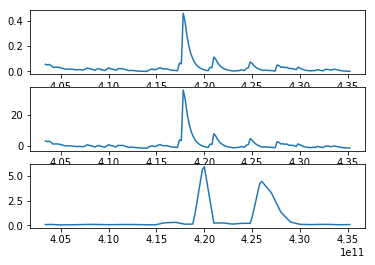

In [87]:
##plot individual cell activity
#raw "pre z score" region
#zscores
#velocity
sample = sample_crossing_indicies[1]
cell = 2
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(C_norm_df.loc[session].iloc[:,cell][sample-80:sample+80]) 
ax2.plot(z_scored_regions_by_session[session][sample].iloc[:,cell])
ax3.plot(V_df.loc[session]['tail_base'][sample-80:sample+80]) 
plt.show()

In [88]:
#concat by mouse 
concacted_by_mouse = {}
for mouse in list(set(session[0:7] for session in list(z_scored_regions_by_session.columns.levels[0]))):
    dfs_by_mouse = []
    sessions = []
    for session in list(z_scored_regions_by_session.columns.levels[0]):
        if mouse in session:
            if not(z_scored_regions_by_session[session].empty):
                means = z_scored_regions_by_session[session].mean(axis=1, level=0)
                dfs_by_mouse.append(means)
                sessions.append(session)
    if len(dfs_by_mouse)>0:
        concacted_by_mouse[mouse] = pd.concat(dfs_by_mouse, axis=1, keys=sessions)
combined_by_mouse = pd.concat(list(concacted_by_mouse.values()), axis=1, keys=list(concacted_by_mouse.keys()))

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 19:13:25.660615. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [89]:
combined_by_mouse.head()

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 19:13:26.696019. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


GRIN035                                            \
                GRIN035_H13_M50_S58                                             
                              422   626   1741  2081  2307  2557  3191  4589    
00:00:11.200000                 NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
00:00:11.400000                 NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
00:00:11.600000                 NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
00:00:11.800000                 NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
00:00:12                        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                             ...             GRIN039                          \
                             ... GRIN039_H12_M26_S54                           
                5416  6158   ...               10521 10722 11432 11936 12911   
00:00:11.200000   NaN   NaN  ...                 NaN   NaN   NaN   NaN   NaN   
00:00:11.400000   NaN   NaN  ...                 NaN   NaN   NaN   NaN   NaN   
00:00:11.600000   NaN   NaN  ...                 NaN   NaN   NaN   NaN   NaN   
00:00:11.800000   NaN   NaN  ...                 NaN   NaN   NaN   NaN   NaN   
00:00:12          NaN   NaN  ...                 NaN   NaN   NaN   NaN   NaN   

                            GRIN026                          
                GRIN026_H16_M35_S34                          
                              902   1112  3807  5448  5777   
00:00:11.200000                 NaN   NaN   NaN   NaN   NaN  
00:00:11.400000                 NaN   NaN   NaN   NaN   NaN  
00:00:11.600000                 NaN   NaN   NaN   NaN   NaN  
00:00:11.800000                 NaN   NaN   NaN   NaN   NaN  
00:00:12                        NaN   NaN   NaN   NaN   NaN  

[5 rows x 70 columns]

In [90]:
combined_by_mouse_timedelta = combined_by_mouse.set_index(pd.to_timedelta(np.linspace(0, (len(combined_by_mouse)-1)*(1/5), len(combined_by_mouse)), unit='s'), drop=True)

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 19:13:33.416792. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 19:13:34.111307. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


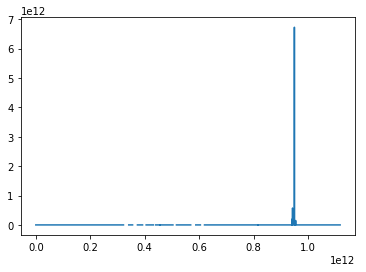

In [91]:
plt.plot(combined_by_mouse_timedelta.mean(axis=1))

In [126]:
#resampled_for_plotting.head()

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 16:57:50.017611. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [127]:
plt.rcParams.update({'font.size': 22})
df_to_plot = resampled_for_plotting
activity_measure = 'spatial_coordination'
x = np.linspace(-(len(df_to_plot)/2)*.5, (len(df_to_plot)/2)*.5, len(df_to_plot))
scale_f = 0.0868
mean=df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f
plt.plot(x, df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f, color='k')
std_error = ((df_to_plot.std(axis=1, level=2)['velocity'])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]))*scale_f
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('velocity cm/sec')
ax.set_xlabel('time (seconds)')
ax.axvline(x=(0), linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('/home/jma819/presentation_files/wt_velocity_spatial_coord_triggered.svg', transparent=True)
fig.subplots_adjust(left=0.15)
fig.savefig('/Users/johnmarshall/Documents/Presentations/Feb20201_LabMeeting/v_triggered.pdf', transparent=True)
plt.show()

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 16:57:55.307120. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


KeyError: 'velocity'

In [128]:
activity_measure = 'fluorescence'
x = np.linspace(-(len(df_to_plot)/2)*.5, (len(df_to_plot)/2)*.5, len(df_to_plot))
mean = df_to_plot.mean(axis=1, level=2)[activity_measure].values
plt.plot(x, mean, color='k')
std_error = (df_to_plot.std(axis=1, level=2)[activity_measure])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]*1)
plt.fill_between(x, mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('dF/F z-score')
ax.set_xlabel('time (seconds)')
ax.axvline(x=0, linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('.svg')
fig.subplots_adjust(left=0.15)
fig.savefig('/Users/johnmarshall/Documents/Presentations/Feb20201_LabMeeting/wt_fluorescence_triggered.pdf', transparent=True)
plt.show()

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2021-02-03 16:58:36.812352. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


KeyError: 'fluorescence'

## event ISIs 

In [10]:
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))

In [11]:
C_df = C_df.drop(['msCamFrame'], axis=1)

In [16]:
ISIs_by_session = []
for session in list(grouped_raw_data.keys()):
    print(session)
    event_indicies, event_times, event_ISIs = utils_jjm.get_ISIs(C_df.loc[session].dropna(axis=1), 20, .1, np.array(C_df.loc[session].dropna(axis=1).columns), 2)
    ISIs_by_session.append(event_ISIs)

GRIN013_H13_M33_S54
GRIN027_H13_M29_S44
GRIN026_H16_M35_S34
GRIN033_H14_M34_S32
GRIN033_H13_M42_S33
GRIN032_H17_M30_S22
GRIN032_H16_M49_S22
GRIN034_H15_M28_S2
GRIN034_H16_M13_S22
GRIN034_H19_M0_S18
GRIN035_H13_M50_S58
GRIN035_H13_M31_S20
GRIN035_H14_M40_S34
